In [1]:
import sys
sys.path.append("..")

import copy
import time
import pickle
import random
import os

import numpy as np
import pandas as pd 
from numpy import matlib as mb
import matplotlib.pyplot as plt


import seaborn as sns 
import pingouin as pg 


#set plotting 
%matplotlib notebook

colours = {'self-motion' : (0.8545098039215687, 0.1415686274509803, 0.14862745098039193),
           'landmark' : (0.24098039215686273, 0.49156862745098046, 0.6962745098039216),
           'combined' : (0.32058823529411773, 0.6664705882352941, 0.31000000000000005),
           'conflict' : (0.5837254901960787, 0.3225490196078431, 0.6225490196078431), 
           'ground' : (0.5837254901960787, 0.3225490196078431, 0.6225490196078431)}

colours['cue-integration'] = 'grey'
colours['a-integration'] = 'grey'
trial_types = {1: 'landmark', 2: 'self-motion', 3: 'combined', 4: 'conflict'}
order = {'self-motion' : 0, 'landmark' : 1, 'combined' : 2, 'conflict' : 3, 'cue-integration' : 4}

from IPython.display import SVG, display
def show_svg(file):
    display(SVG(filename=file))

/Users/fabiankessler/.pyenv/versions/3.9.9/envs/statistics/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/fabiankessler/.pyenv/versions/3.9.9/envs/statistics/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Nardini 2008 

272
271


/Users/fabiankessler/.pyenv/versions/3.9.9/envs/statistics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/fabiankessler/.pyenv/versions/3.9.9/envs/statistics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


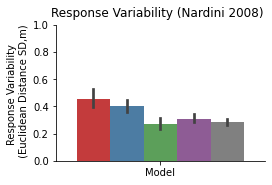

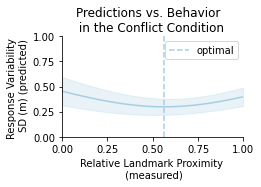

In [2]:
#### Nardini 2008
%matplotlib inline
from IPython.display import SVG, display
def show_svg(file):
    display(SVG(filename=file))

path = '../temp_figures/'


import seaborn as sns

#import functions 
from analysis.nardini2008.utils import * 
from analysis.nardini2008.preprocessing import preprocess_nardini_2008, preprocress_per_participant
from analysis.nardini2008.cue_integration_model import cue_integration_nardini2008_model
from analysis.nardini2008.pipeline import plot_all_conditions, extract_SDs

from analysis.key_plots import plot_endpoint_variability, plot_raw_endpoints, annotate_plot
from analysis.endpoint_comparison import * 

################################################################################################
                                    ### Endpoint Analysis ###
################################################################################################

# _____________________________________ Data Normalized ________________________________________ #
dataset_simulated = pd.read_csv('../data/nardini2008_endpoint_data.csv')
normalized_data_simulated, SDs_simulated = preprocess_nardini_2008(dataset_simulated, 
                                                                   remove_outliers=True, 
                                                                   normalize=True, 
                                                                   flip_conclict=True)

# generate nardini plot 
output = plot_all_conditions(path, normalized_data_simulated)
output.save(path + 'nardini_model_simulation_colours.svg')
show_svg(path + 'nardini_model_simulation_colours.svg')

# _____________________________________ Cue Integration Analysis ________________________________________ #

temp_dfs = [] 
for VP, data in normalized_data_simulated.groupby('VPCode'): 
    SDs, results = cue_integration_nardini2008_model(data)
    
    #includes the prediction
    prediction = {'VPCode' : SDs.VPCode.iloc[0], 'condition' : 'cue-integration', 'x' : 0, 'y' : 0, 'SD' : np.sqrt(results['sigmas']['cue-integration']), 'kind' : 'Model', 'order' : order['cue-integration']}
    SDs = pd.concat([SDs, pd.DataFrame(prediction, index = [0])])
    temp_dfs.append(SDs)

    
SDs = pd.concat(temp_dfs)
SDs = SDs.reset_index()
SDs_simulated = SDs.sort_values('order', ascending=True)
SDs_simulated['kind'] = 'Model'

SDs_full = SDs_simulated
SDs_full['VPCode'] = SDs_full['VPCode'].astype(str)


hue_order = ['self-motion', 'landmark', 'combined', 'conflict', 'cue-integration']

### Plot Functions 
path = '../../../figures/'
plt.figure(figsize = (3.75,3.75/1.5))    
p = sns.barplot(x = 'kind', y = 'SD', hue = 'condition', hue_order=hue_order ,data = SDs_full, palette=colours)
plt.suptitle('Response Variability (Nardini 2008)')
plt.ylabel('Response Variability \n (Euclidean Distance SD,m)')
plt.xlabel('')
plt.ylim(0,1)
#plt.yticks(np.arange(0,1.1,0.1))
#p.legend(fontsize=10)
p.legend_.remove()
sns.despine()

# _____________________________________ Predictions & Conflict Conditions ________________________________________ #

x = np.linspace(0,1,100)

paired_colors = sns.color_palette("Paired", 2)

def compute_d_nardini_formula(mean_locations, rotated_target_location = np.array([ 0.45293333 -0.0596298 ])):
    d_lm = np.linalg.norm(rotated_target_location -  mean_locations['conflict'])
    d_sm = np.linalg.norm(np.zeros(2) -  mean_locations['conflict'])
                              
    return d_lm, d_sm

#equation 1
def relative_proximity(d_lm, d_sm): 
    rprox_lm = d_sm / (d_sm + d_lm)
    rprox_sm = 1 - rprox_lm
    return rprox_lm, rprox_sm

def get_combined_variance(w, sm, lm):
    return (1-w)**2 * sm + w**2 * lm


def calculate_cue_weights(sigma_lm, sigma_sm): 
    w_lm = sigma_sm / (sigma_lm + sigma_sm)
    w_sm = 1 - w_lm 
    return w_lm, w_sm  




x = np.linspace(0,1,1000)



plt.figure(figsize = (3.25, 3.25 / 1.75))

VPs_rprox = {}
VPs_cue_weight = {}

for VP, vp_data in SDs_full.groupby('VPCode'):
    resp_means = {}
    
    for cond, cond_data in vp_data.groupby('condition'):
        resp_means[cond] = cond_data[['x','y']].values
        
    d_lm, d_sm = compute_d_nardini_formula(resp_means)
    sigma_sm = vp_data[vp_data.condition == 'self-motion']['SD'].values**2 
    sigma_lm = vp_data[vp_data.condition == 'landmark']['SD'].values**2 
    
    rprox_lm, rprox_sm = relative_proximity(d_lm, d_sm)
    w_lm, w_sm = calculate_cue_weights(sigma_lm, sigma_sm)
    
    VPs_rprox[VP] = rprox_lm
    VPs_cue_weight[VP] = w_lm
    
    
SDs_full['rp'] = SDs_full.apply(lambda x : VPs_rprox[x['VPCode']], axis = 1)
SDs_full['w_lm'] = SDs_full.apply(lambda x : VPs_cue_weight[x['VPCode']], axis = 1)


SDs = (SDs_full.groupby(['condition', 'kind']).mean()).to_dict()['SD']
sm_variance =  SDs[('self-motion', 'Model')]**2
lm_variance =  SDs[('landmark', 'Model')]**2
combined_variance = SDs[('combined', 'Model')]**2
conflict_variance = SDs[('conflict', 'Model')]**2
y_model_mean = np.sqrt(get_combined_variance(x, sm_variance, lm_variance))

SDs = (SDs_full.groupby(['condition', 'kind']).mean() + SDs_full.groupby(['condition', 'kind']).std()).to_dict()['SD']
sm_variance =  SDs[('self-motion', 'Model')]**2
lm_variance =  SDs[('landmark', 'Model')]**2
combined_variance = SDs[('combined', 'Model')]**2
conflict_variance = SDs[('conflict', 'Model')]**2
y_model_upper = np.sqrt(get_combined_variance(x, sm_variance, lm_variance))


SDs = (SDs_full.groupby(['condition', 'kind']).mean() - SDs_full.groupby(['condition', 'kind']).std()).to_dict()['SD']
sm_variance =  SDs[('self-motion', 'Model')]**2
lm_variance =  SDs[('landmark', 'Model')]**2
combined_variance = SDs[('combined', 'Model')]**2
conflict_variance = SDs[('conflict', 'Model')]**2
y_model_lower = np.sqrt(get_combined_variance(x, sm_variance, lm_variance))


plt.plot(x, y_model_mean, color = paired_colors[0])
plt.fill_between(x, y_model_lower, y_model_upper, alpha = 0.25, color = paired_colors[0])


plt.axvline(x[np.argmin(y_model_mean)], label = 'optimal', color = paired_colors[0], ls = '--')

combined_sds = SDs_full[SDs_full.condition == 'conflict']

combined_sds_model = combined_sds[combined_sds.kind == 'Model']


plt.suptitle('Predictions vs. Behavior \n in the Conflict Condition', y = 1.1)
plt.xlim(0,1)
plt.ylim(0,1)

plt.xticks(np.arange(0,1.25,0.25))
plt.yticks(np.arange(0,1.1,0.25))

plt.xlabel('Relative Landmark Proximity \n (measured)')
plt.ylabel('Response Variability \n SD (m) (predicted)')

plt.legend()
sns.despine()

# Chen 2017 

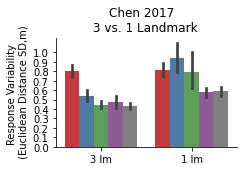

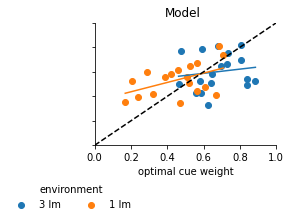

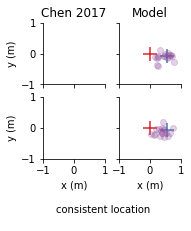

In [3]:
# Chen 2017 
%matplotlib inline

import seaborn as sns

#path 
path = '../temp_figures/'

#import functions 
from analysis.chen2017.data_loading import load_chen_data, process_simulated_data
from analysis.chen2017.utils import * 
from analysis.chen2017.preprocessing import preprocess_data_chen_2017, preprocess_per_participant
from analysis.chen2017.cue_integration_model import chen_2017_cue_integration_model, compute_cue_weights, compute_sds_per_vp
from analysis.chen2017.pipeline import * 

from analysis.key_plots import *
from analysis.endpoint_comparison import * 

from IPython.display import SVG, display
def show_svg(file):
    display(SVG(filename=file))

################################################################################################
                                    ### Endpoint Analysis ###
################################################################################################
poor_dataset_simulated = pd.read_csv('../data/chen2017_poor_endoint_data.csv')
rich_dataset_simulated = pd.read_csv('../data/chen2017_rich_endoint_data.csv')

# _____________________________________ Data Normalized ________________________________________ #

#normalize data via chen preprocessing pipeline 

#add the target jitter to the response coordinates prior to normalization
rich_dataset_simulated[['targetx', 'targetz']] += rich_dataset_simulated[['jitterx', 'jitterz']].values
poor_dataset_simulated[['targetx', 'targetz']] += poor_dataset_simulated[['jitterx', 'jitterz']].values


#rich 
rich_normalized_data_simulated = preprocess_data_chen_2017(rich_dataset_simulated, recenter = False, remove_outliers=True, iqr = 3)
per_condition_plot = generate_per_condition_plot(rich_normalized_data_simulated, path = path)
show_svg(per_condition_plot)

#poor 
poor_normalized_data_simulated = preprocess_data_chen_2017(poor_dataset_simulated, recenter = False, remove_outliers=True, iqr = 3)
per_condition_plot = generate_per_condition_plot(poor_normalized_data_simulated, path = path)
show_svg(per_condition_plot)

# _____________________________________ Cue Integration Analysis ________________________________________ #

#simulated 
rich_sds_simulated = compute_sds_per_vp(rich_dataset_simulated, environment = 'rich', kind = 'Model')
poor_sds_simulated = compute_sds_per_vp(poor_dataset_simulated, environment = 'poor', kind = 'Model')

rich_sds_simulated['SD'] = rich_sds_simulated['value']
poor_sds_simulated['SD'] = poor_sds_simulated['value']


rich_sds_simulated['environment'] = '3 lm'
poor_sds_simulated['environment'] = '1 lm'


# Plotting 
figsize = (3.25,2)

import seaborn as sns 
plt.figure(figsize = figsize)    
p = sns.barplot(x = 'environment', y = 'value', hue = 'condition', data = pd.concat([rich_sds_simulated, poor_sds_simulated]), palette = colours)
plt.suptitle('Response Variability')
plt.ylabel('sd (m)')
plt.xlabel('')
#plt.ylim(0,1.5)
plt.yticks(np.arange(0,1.1,0.1))
p.legend(fontsize=10)
p.legend_.remove()
sns.despine()
plt.suptitle('Chen 2017 \n 3 vs. 1 Landmark', y = 1.1)
plt.ylabel('Response Variability \n (Euclidean Distance SD,m)')
plt.show()



################################################################################################
                                    ### Additional Analysis ###
################################################################################################

# _____________________________________ Cue Weight Regression Analysis ________________________________________ #

import statsmodels.api as sm


def fit_OLS(predicted, empirical):
    x = predicted
    y = empirical
    X = sm.add_constant(predicted)

    model = sm.OLS(y, X)
    results = model.fit()

    return model, results


#Simulated (Model)
VPs_rich, predicted_rich, empirical_rich = compute_cue_weights(rich_dataset_simulated)
VPs_poor, predicted_poor, empirical_poor = compute_cue_weights(poor_dataset_simulated)


plt.figure(figsize = (3.25,2.25))

plt.scatter(predicted_rich, empirical_rich, label = '3 lm')
plt.scatter(predicted_poor, empirical_poor, label = '1 lm')

model, results_simulated_rich = fit_OLS(predicted_rich, empirical_rich)
xfit = np.linspace(np.min(predicted_rich), np.max(predicted_rich), 1000)
X = sm.add_constant(xfit)
yfit = results_simulated_rich.predict(X)
plt.plot(xfit, yfit);

model, results_simulated_poor = fit_OLS(predicted_poor, empirical_poor)
xfit = np.linspace(np.min(predicted_poor), np.max(predicted_poor), 1000)
X = sm.add_constant(xfit)
yfit = results_simulated_poor.predict(X)
plt.plot(xfit, yfit);

#combined
model, results_simulated_combined = fit_OLS(predicted_rich + predicted_poor, empirical_rich + empirical_poor)
xfit = np.linspace(np.min(predicted_rich), np.max(predicted_rich), 1000)
X = sm.add_constant(xfit)
yfit = results_simulated_combined.predict(X)
#plt.plot(xfit, yfit);


plt.plot((0,1), (0,1), ls = '--', color = 'black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('optimal cue weight')
plt.ylabel('')
plt.suptitle('Model')
#print(model.coef_)
#print(model.intercept_)
frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

sns.despine()
plt.legend(frameon = False, bbox_to_anchor=(0.25, -0.25), title = 'environment', ncol = 2)


# _____________________________________ Response Mean Analysis ________________________________________ #

fig, ax = plt.subplots(2,2, figsize = (2.5,2.5), sharex=True, sharey=True)
use_response_bias_cleared_means = False

ax[0,0].set_xlim(-1,1)
ax[0,0].set_ylim(-1,1)
ax[0,0].set_xticks(np.arange(-1,1.5, 1))
ax[0,0].set_yticks(np.arange(-1,1.5, 1))
ax[0,0].set_ylim(-1,1)

ax[0,0].set_title('Chen 2017')
ax[0,1].set_title('Model')

conflict_data = rich_normalized_data_simulated[rich_normalized_data_simulated.condition == 'conflict']
landmark_data = rich_normalized_data_simulated[rich_normalized_data_simulated.condition == 'landmark']
conflict_means = conflict_data.groupby('VPCode').mean()[['x', 'y']].values
cleared_means = (conflict_data.groupby('VPCode').mean()[['x', 'y']] - landmark_data.groupby('VPCode').mean()[['x', 'y']]).values

ax[0,1].scatter(0,0, marker = '+', s = 200, color = colours['self-motion'])
ax[0,1].scatter(0.55774169,-0.073428087, marker = '+', s = 200, color = colours['landmark'])

if use_response_bias_cleared_means:
    ax[0,1].scatter(cleared_means[:,0], cleared_means[:,1], color = colours['conflict'], alpha = 0.25)
else:
    ax[0,1].scatter(conflict_means[:,0], conflict_means[:,1], color = colours['conflict'], alpha = 0.25)

conflict_data = poor_normalized_data_simulated[poor_normalized_data_simulated.condition == 'conflict']
landmark_data = poor_normalized_data_simulated[poor_normalized_data_simulated.condition == 'landmark']
conflict_means = conflict_data.groupby('VPCode').mean()[['x', 'y']].values
cleared_means = (conflict_data.groupby('VPCode').mean()[['x', 'y']] - landmark_data.groupby('VPCode').mean()[['x', 'y']]).values

ax[1,1].scatter(0,0, marker = '+', s = 200, color = colours['self-motion']) #self-motion prediction
ax[1,1].scatter(0.55774169,-0.073428087, marker = '+', s = 200, color = colours['landmark']) #landmark prediction 

if use_response_bias_cleared_means:
    ax[1,1].scatter(cleared_means[:,0], cleared_means[:,1], color = colours['conflict'], alpha = 0.25)
else:
    ax[1,1].scatter(conflict_means[:,0], conflict_means[:,1], color = colours['conflict'], alpha = 0.25)

    
#ax[1,1].set_title('poor')

ax[1,0].set_aspect('equal')
ax[0,1].set_aspect('equal')
ax[1,1].set_aspect('equal')
ax[0,0].set_aspect('equal')


ax[0,0].set_ylabel('y (m)')
ax[1,0].set_ylabel('y (m)')
ax[1,0].set_xlabel('x (m)')
ax[1,1].set_xlabel('x (m)')

#plt.suptitle('Subject Mean Responses \n in Conflict Conditions')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = 'lower center', bbox_to_anchor=(0.415, -0.265, 0.1, 0.4), ncol = 2, title = 'consistent location', frameon = False)

sns.despine()

# Zhao 2015 

data loading


cue integration analysis (circular)
    proximal
sub02
sub03
sub04
sub06
sub07
sub08
    distal
sub01
sub03
sub05
sub08
sub11


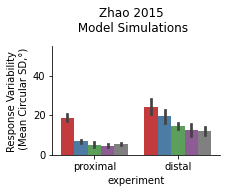

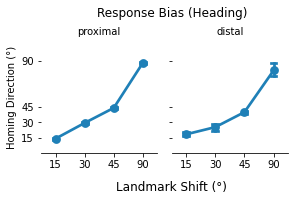

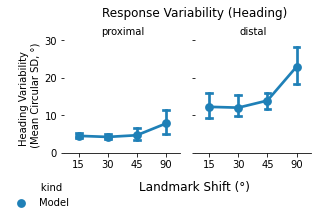

In [4]:
# Zhao 2015 
%matplotlib inline

#path 
path = '../temp_figures/'

annotate = True

#import functions 
from analysis.zhao2015.data_loading import load_zhao_data,load_zhao_data_simulated
from analysis.zhao2015.utils import * 
from analysis.zhao2015.preprocessing import fit_von_mises, fit_von_mises_per_condition_df, normalize_data_by_conflict_condition, remove_outliers_heading_direction, normalize_data_empirical
from analysis.zhao2015.cue_integration_model import zhao_2015a_cue_integration_model, evaluate_zhao_cue_integration
from analysis.zhao2015.pipeline import *

from analysis.key_plots import *
from analysis.endpoint_comparison import * 

import seaborn as sns
from IPython.display import SVG, display
def show_svg(file):
    display(SVG(filename=file))
    
    
def normalize_data_empirical(dataset_empirical):
    #Empirical 
    normalized_data_empirical = []
    for condition, data in dataset_empirical.groupby('condition'):
        #flip x coordinates to one side for conflict condition
        if condition.split('_')[0] == 'conflict':
            normalized = normalize_data_by_conflict_condition(data, return_dataframe=True)
            if condition.split('_')[3] == 'left':
                normalized['x'] = - normalized['x']
        else:
            normalized = normalize_data_by_conflict_condition(data, return_dataframe=True)

        normalized_data_empirical.append(copy.deepcopy(normalized))

    normalized_data_empirical = pd.concat(normalized_data_empirical)
    
    return normalized_data_empirical


################################################################################################
                                    ### Endpoint Analysis ###
################################################################################################

# _____________________________________ Data Loading ________________________________________ #

print('data loading')
proximal_dataset_simulated = pd.read_csv('../data/zhao2015_proximal_endpoint_data.csv')
distal_dataset_simulated = pd.read_csv('../data/zhao2015_distal_endpoint_data.csv')

# _____________________________________  Normalize Data ________________________________________ #

proximal_normalized_data_simulated = normalize_data_simulated(proximal_dataset_simulated)
distal_normalized_data_simulated = normalize_data_simulated(distal_dataset_simulated)

# remove heading outliers 
proximal_normalized_data_simulated = remove_outliers_heading_direction(proximal_normalized_data_simulated) 
distal_normalized_data_simulated = remove_outliers_heading_direction(distal_normalized_data_simulated) 
proximal_normalized_data_simulated['condition'] = proximal_normalized_data_simulated.condition.apply(lambda x : x.split('_')[0])
distal_normalized_data_simulated['condition'] = distal_normalized_data_simulated.condition.apply(lambda x : x.split('_')[0])

# _____________________________________ Plot Data Normalized ________________________________________ #

all_plot, conflict_plot = generate_endpoint_plot(proximal_normalized_data_simulated, 'proximal', path, limit = 5.5, center = False, flip = True)
show_svg(all_plot)
show_svg(conflict_plot)

all_plot, conflict_plot = generate_endpoint_plot(distal_normalized_data_simulated, 'distal', path, limit = 5.5, center = False, flip = True)
show_svg(all_plot)
show_svg(conflict_plot)

print('cue integration analysis (circular)')


#remove extreme conflict conditions 
proximal_dataset_simulated = proximal_dataset_simulated[proximal_dataset_simulated.landmark_rotation < 100]
distal_dataset_simulated = distal_dataset_simulated[distal_dataset_simulated.landmark_rotation < 100]

#Computing 
VP_cue_integration_simulated = {}
cue_integration_results = []

recenter = True

for experiment, dataset_simulated in zip(['proximal', 'distal'], [proximal_dataset_simulated, distal_dataset_simulated]):
    print('    ' + experiment)
    
    VPs_simulated = []
    
    for VP, data in dataset_simulated.groupby('VPCode'):
        print(VP)
        #data = remove_per_side_bias(data)
        full_data = data 
        
        if recenter:
            condition_data = copy.deepcopy(data[data['condition'] != 'conflict'])
            condition_data['condition'] = condition_data['condition'] + '_' + condition_data['target'].astype(str)

            conflict_data = copy.deepcopy(data[data['condition'] == 'conflict'])
            conflict_data['condition'] = conflict_data['condition'] + '_' + conflict_data['target'].astype(str) + '_' + conflict_data['landmark_rotation'].astype(str) + '_' + conflict_data['lmturn'].astype(str)

            full_data = pd.concat([condition_data, conflict_data])
        
        normalized_data = normalize_data_empirical(full_data)
        
        results_simulated = zhao_2015a_cue_integration_model(normalized_data)
        results_simulated['full data']['VPCode'] = VP + ' '  + experiment
        results_simulated['full data']['experiment'] = experiment
        
        VP_cue_integration_simulated[VP + ' '  + experiment] = results_simulated
        VPs_simulated.append(VP + ' '  + experiment)

    for VP in VPs_simulated:
        full_results = evaluate_zhao_cue_integration(results = VP_cue_integration_simulated[VP], kind = 'Model')
        full_results['VPCode'] = VP
        full_results['experiment'] = experiment
        cue_integration_results.append(full_results)

cue_integration_results = pd.concat(cue_integration_results)
cue_integration_results['SD'] = cue_integration_results['circ_sd'] 
cue_integration_results['VPCode'] = cue_integration_results['VPCode'] + '_' +  cue_integration_results['kind']


#both experiments
plt.figure(figsize = (3.0,2))    
p = sns.barplot(x = 'experiment', y = 'circ_sd', hue = 'condition', data = cue_integration_results, palette=colours)
plt.ylim(0,55)
plt.ylabel('Response Variability \n (Mean Circular SD,°)')
plt.suptitle('Zhao 2015 \n Model Simulations ', y = 1.15)
sns.despine()
p.legend_.remove()
plt.show()

# _____________________________________ Cue Integration Analysis (Linear) ______________________________________ #

simulated = pd.concat([VP_cue_integration_simulated[VP]['full data'] for VP in VP_cue_integration_simulated.keys()])
simulated['kind'] = 'Model'
simulated['theta_deg'] = -simulated['theta_deg']

all_data = pd.concat([simulated])
all_data = all_data[all_data.condition == 'conflict']
all_data = all_data[all_data.landmark_rotation <= 90.0]

g = sns.catplot(x="landmark_rotation", y="theta_deg", hue="kind", col="experiment",
                capsize=.2, palette="YlGnBu_d", height=2.5, aspect=.85,
                kind="point", data=all_data)


g.despine(left=True)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels('')
g.axes[0,0].set_ylabel('Homing Direction (°)')
g.figure.suptitle('Response Bias (Heading)', y = 1.05)
g.figure.supxlabel('Landmark Shift (°)')

g.set(ylim = (0,110), yticks = [15,30,45,90])



g._legend.remove()
#plt.savefig(path + 'zhao_2015_vs_model_simulation_heading_direction.svg')

g = sns.catplot(x="landmark_rotation", y="circ_sd", hue="kind", col="experiment",
                capsize=.2, palette="YlGnBu_d", height=2.5, aspect=.85,
                kind="point", data=all_data)

g.despine(left=True)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels('')
g.axes[0,0].set_ylabel('Heading Variability \n (Mean Circular SD, °)')
g.figure.suptitle('Response Variability (Heading)', y = 1.05)
g.figure.supxlabel('Landmark Shift (°)')
g._legend.remove()


g.set(ylim = (0,30), yticks = [0,10,20,30])

plt.legend(frameon = False, ncol = 2, bbox_to_anchor = (-1,-0.185,0,0), title = '       kind')

plt.savefig(path + 'zhao_2015_vs_model_simulation_heading_variability.svg', transparent = True)